#**Imports**

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import numpy as np


from sklearn.linear_model import Lasso, LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

#**Dataset**

In [56]:
df_train = pd.read_csv("Dataset/housing_coursework_train.csv", encoding="ISO-8859-1")
df_test = pd.read_csv("Dataset/housing_coursework_test.csv", encoding="ISO-8859-1")


In [57]:
df_train.head(10)

,No.,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,1,-122.21,37.83,34,5065,788.0,1627,766,6.8976,333300,NEAR BAY
1,2,-122.22,37.77,52,391,128.0,520,138,1.6471,95000,NEAR BAY
2,3,-122.23,37.79,30,610,145.0,425,140,1.6198,122700,NEAR BAY
3,4,-122.20,37.78,52,2300,443.0,1225,423,3.5398,158400,NEAR BAY
4,5,-122.19,37.79,50,954,217.0,546,201,2.6667,172800,NEAR BAY
5,6,-122.19,37.76,26,1293,297.0,984,303,1.9479,85800,NEAR BAY
6,7,-122.17,37.74,43,818,193.0,494,179,2.4776,101600,NEAR BAY
7,8,-122.18,37.75,46,941,218.0,621,195,1.3250,87100,NEAR BAY
8,9,-122.16,37.75,38,2457,624.0,1516,482,1.5625,91700,NEAR BAY
9,10,-122.14,37.75,33,1334,200.0,579,202,6.8323,255900,NEAR BAY


In [58]:
def scatter_plot(feature, target):
    plt.figure(figsize=(8, 4))
    plt.scatter(
        df_train[feature],
        df_train[target],
        c='black'
    )
    plt.xlabel(feature)
    plt.ylabel(target)
    plt.show()

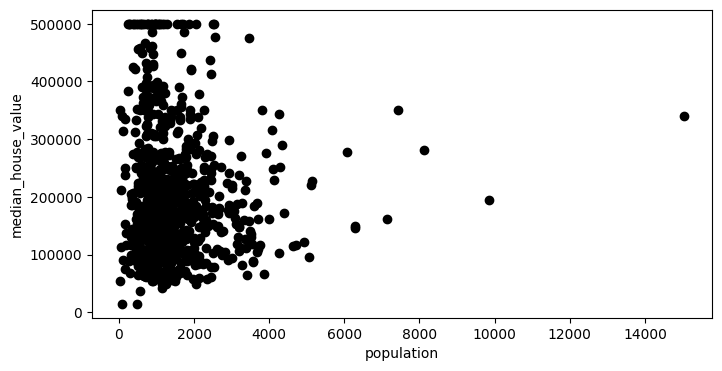

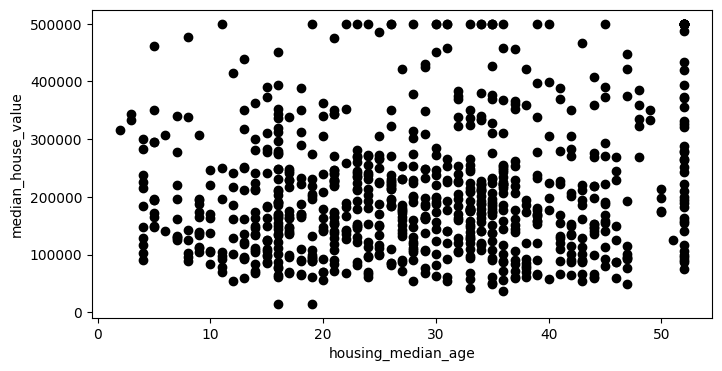

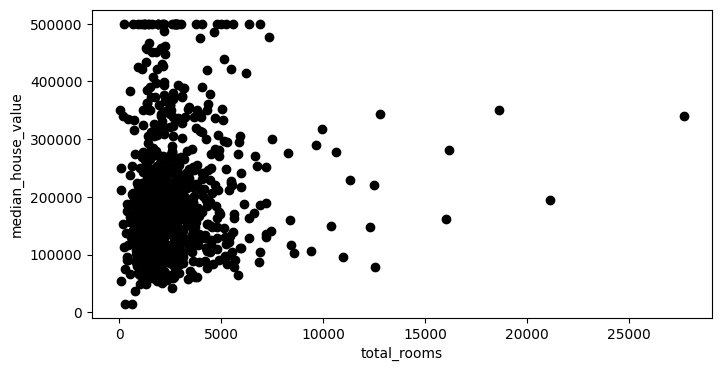

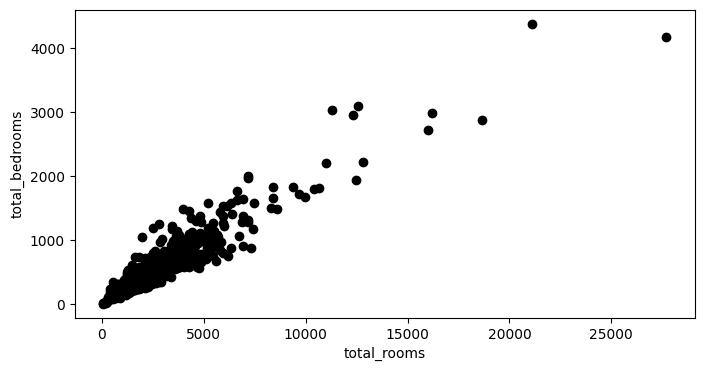

In [59]:
#Attempting to identifying correlations
scatter_plot('population', 'median_house_value')
scatter_plot('housing_median_age', 'median_house_value')
scatter_plot('total_rooms', 'median_house_value')
scatter_plot('total_rooms', 'total_bedrooms')


#**Preprocessing**

In [60]:
#Detecting NaN vaues
print("Trainin set: \n",df_train.loc[df_train.isnull().any(axis=1)])
print("Test set: \n",df_test.loc[df_test.isnull().any(axis=1)])

Trainin set: 
      No.  longitude  latitude  housing_median_age  total_rooms  \
72    73    -122.08     37.88                  26         2947   
168  169    -118.28     34.25                  29         2559   
236  237    -118.38     34.05                  49          702   
548  549    -117.87     33.83                  27         2287   
621  622    -116.21     33.75                  22          894   
740  741    -117.02     32.66                  19          771   
786  787    -122.45     37.77                  52         2602   
792  793    -122.50     37.75                  45         1620   

     total_bedrooms  population  households  median_income  \
72              NaN         825         626         2.9330   
168             NaN        1886         769         2.6036   
236             NaN         458         187         4.8958   
548             NaN        1140         351         5.6163   
621             NaN         830         202         3.0673   
740             Na

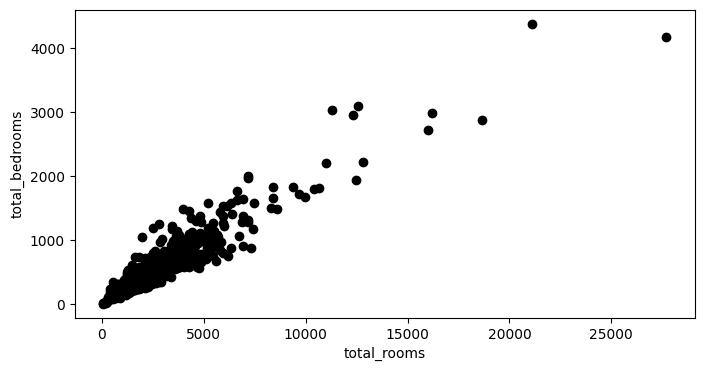

In [61]:
#Filling Nan total_bedrooms data points with using the average ratio of bedrooms to total rooms.
scatter_plot('total_rooms', 'total_bedrooms')

sum_total_rooms = df_train['total_rooms'].sum()

sum_total_bedrooms = df_train['total_bedrooms'].sum()

average_room_bedroom_ratio = sum_total_bedrooms/sum_total_rooms
for index, row in df_train.iterrows():
    if(np.isnan(row['total_bedrooms'])):
        df_train.at[index, 'total_bedrooms',] = row['total_rooms'] * average_room_bedroom_ratio

sum_total_rooms = df_test['total_rooms'].sum()

sum_total_bedrooms = df_test['total_bedrooms'].sum()

average_room_bedroom_ratio = sum_total_bedrooms/sum_total_rooms
for index, row in df_test.iterrows():
    if(np.isnan(row['total_bedrooms'])):
        df_test.at[index, 'total_bedrooms',] = row['total_rooms'] * average_room_bedroom_ratio

In [62]:
#Shuffle dataset
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_train.head(10)

df_test = df_test.sample(frac=1).reset_index(drop=True)
df_test.head(10)


,No.,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,924,-122.45,41.28,15,2740,503.0,1188,445,3.4519,128800,INLAND
1,1007,-118.86,34.19,29,1326,185.0,586,187,6.5474,422900,<1H OCEAN
2,919,-122.33,40.47,30,2502,523.0,1296,481,2.1250,66100,INLAND
3,966,-120.84,37.49,25,2383,576.0,1234,583,1.4529,86100,INLAND
4,1006,-118.85,34.21,29,2195,414.0,1360,401,3.4773,206700,<1H OCEAN
5,939,-122.68,38.48,15,1575,262.0,716,259,5.3409,244600,<1H OCEAN
6,825,-120.64,35.15,7,7922,1442.0,2863,1197,4.8490,275000,<1H OCEAN
7,978,-119.40,36.55,19,3000,628.0,2202,590,2.5141,67400,INLAND
8,810,-121.28,38.14,38,2803,500.0,1223,509,4.1190,128800,INLAND
9,828,-122.48,37.71,39,3615,632.0,1571,615,5.1149,314200,NEAR OCEAN


In [63]:
# Integer encoding ocean proximity
df_train['ocean_proximity']=np.where(df_train['ocean_proximity'] == 'INLAND', 0,
                            np.where(df_train['ocean_proximity'] == '<1H OCEAN', 1,
                            np.where(df_train['ocean_proximity'] == 'NEAR OCEAN', 2,
                            np.where(df_train['ocean_proximity'] == 'NEAR BAY', 3 , df_train['ocean_proximity']))))

df_test['ocean_proximity']=np.where(df_test['ocean_proximity'] == 'INLAND', 0,
                            np.where(df_test['ocean_proximity'] == '<1H OCEAN', 1,
                            np.where(df_test['ocean_proximity'] == 'NEAR OCEAN', 2,
                            np.where(df_test['ocean_proximity'] == 'NEAR BAY', 3 , df_test['ocean_proximity']))))                           
df_train.head(10)

,No.,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,594,-121.32,38.89,9,5927,1269.0,3369,1176,2.8194,111300,0
1,174,-118.42,34.26,37,1789,424.0,2279,411,3.9000,138600,1
2,57,-120.91,38.11,9,3585,680.0,1800,598,3.6360,133100,0
3,402,-118.15,33.77,52,2204,498.0,899,445,4.1765,393900,2
4,116,-122.74,39.71,16,255,73.0,85,38,1.6607,14999,0
5,745,-117.01,32.76,22,3626,824.0,1800,769,2.8594,189600,1
6,141,-119.04,35.31,11,2161,371.0,1267,388,4.1957,92700,0
7,430,-118.40,33.78,24,4787,562.0,1653,548,12.9758,500001,2
8,152,-118.46,35.13,19,3109,640.0,1457,620,2.6417,94900,0
9,795,-122.49,37.78,52,3440,722.0,1663,665,3.0278,356300,3


In [64]:
# Dropping unnecessary columns
df_train= df_train.drop(columns=['No.'])


df_test = df_test.drop(columns=['No.'])

df_train.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-121.32,38.89,9,5927,1269.0,3369,1176,2.8194,111300,0
1,-118.42,34.26,37,1789,424.0,2279,411,3.9000,138600,1
2,-120.91,38.11,9,3585,680.0,1800,598,3.6360,133100,0
3,-118.15,33.77,52,2204,498.0,899,445,4.1765,393900,2
4,-122.74,39.71,16,255,73.0,85,38,1.6607,14999,0
5,-117.01,32.76,22,3626,824.0,1800,769,2.8594,189600,1
6,-119.04,35.31,11,2161,371.0,1267,388,4.1957,92700,0
7,-118.40,33.78,24,4787,562.0,1653,548,12.9758,500001,2
8,-118.46,35.13,19,3109,640.0,1457,620,2.6417,94900,0
9,-122.49,37.78,52,3440,722.0,1663,665,3.0278,356300,3


In [65]:
#Splitting the data
X_train= df_train.drop(columns=['median_house_value'])

y_train= df_train['median_house_value']

X_test= df_test.drop(columns=['median_house_value'])
y_test= df_test['median_house_value']

#**Training and tuning**

Linear Regression

In [66]:
linearreg_model = LinearRegression().fit(X_train, y_train)

Lasso Regression

In [67]:
#Trial and error tuning through GridSearch
parameters = {'alpha': [0.2, 0.3 ,0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}
gridsearchCV = GridSearchCV(Lasso(), parameters,refit=True,scoring='r2')
gridsearchCV.fit(X_train,y_train)
best_alpha = gridsearchCV.best_params_['alpha']
gridsearchCV_model= Lasso(alpha=best_alpha)
gridsearchCV_model.fit(X_train,y_train)

Lasso(alpha=1)

#**Final Results**

In [68]:
print("Actual Price:" , df_test['median_house_value'].head(1)[0])
print("--------------")
y_pred = gridsearchCV_model.predict(X_test)
print("GridSearch:", gridsearchCV_model.predict(X_test.head(1))[0])
print("Model Score:",r2_score(y_test, y_pred))
print("--------------")
y_pred = linearreg_model.predict(X_test)
print("GridSearch:", linearreg_model.predict(X_test.head(1))[0])
print("Model Score:",r2_score(y_test, y_pred))



Actual Price: 128800
--------------
GridSearch: 45237.06445810106
Model Score: 0.711575541128604
--------------
GridSearch: 45225.25042564515
Model Score: 0.7115763816902869
